---

**Projet Hackathon : Quelle(s) énergie(s) pour demain ?**

---

L'objet de l'étude était de prévoir au niveau mondial quelle serait l'énergie de demain.
Nous avons récupéré sur les trente dernières années la consommation mondiale par pays et par énergie. 
Nous avons voulu être le plus exhaustif possible en traitant les énergies suivantes :
* Pétrole
* Gaz
* Charbon
* Nucléaire
* Hydraulique
* Solaire
* Energie renouvelable
* Vent

**Objectif :**

Notre objectif était de prédire via des modèles de Machine Learning l'évolution mondiale et par grande région :
- de la production énergétique
- du mix énergétique

**Méthodo :**

Nous avons pour cela procédé en plusieurs phases : 
1. **Récupération** des données intéressantes. Nous avons identifié les données suivantes :
   - données démographiques (évolution de la population, de l'urbanisation, de la richesse...)
   - données relatives à l'émission des principaux gaz à effet de serre (CO2, méthane, protoxyde d'azote)
   - données relatives à la production énergétiques (volumes, distribution par pays, par type d'éenergies...)
   - données relative à la consommation énergétiques des différents secteurs d'activité (la mauvaise qualité des  données trouvées et le peu de temps imparti ne nous a malheureusement pas permis de les exploiter dans nos modèles prédictifs / dans la visualisation)
2. **Exploration** des données :
    - Nettoyage
    - Visualisation
    - Recherche de corrélations
3. **Sélection** des données utiles pour répondre à notre objectif ie construire un modèle prédictif
4. **Modélisation** via des tests de différents modèles


Sources des jeux de données utilisés : 
- https://data.worldbank.org/.
- BP Statistical Review 2018 qui agrège les données énergétiques depuis 1965.

**Imports de librairies**

In [88]:
# Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set(color_codes=True)
import plotly.graph_objects as go
from pandas.plotting import autocorrelation_plot

# Machine Learning
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Autres 
import numpy as np
import pandas as pd
from random import random
import os
from datetime import datetime

# Etude démographique 

La première étape de notre travail est une analyse démographique ainsi qu'une analyse des émissions de gaz à effet de serre.

On s'intéresse ici notamment à l'évolution :
- de la population
- de l'urbanisation
- de la richesse
- de l'émission de CO2
- de l'émission de méthane
- de l'émission de protoxyde d'azote

In [5]:
path = '/'.join(os.getcwd().split("/")[:-1])

urban_population = pd.read_csv(f'{path}/data/Urban-population-by-country.csv', skiprows=4)
population_growth = pd.read_csv(f'{path}/data/Population-growth-by-country.csv', skiprows=4)
population = pd.read_csv(f'{path}/data/Population-by-country.csv', skiprows=4)
access_electricity = pd.read_csv(f'{path}/data/Access-to-electricity-by-country.csv', skiprows=4)
nitrous_oxyd_emission = pd.read_csv(f'{path}/data/Nitrous-oxyd-emission.csv',skiprows=4)
gdp = pd.read_csv(f'{path}/data/gdp.csv',skiprows=4)
methan_emission = pd.read_csv(f'{path}/data/Methan-emission-by-country.csv',skiprows=4)
co2_emission = pd.read_csv(f'{path}/data/emission_CO2.csv',skiprows=4)

In [6]:
def clean_all_df(df, value):
    df_copy = df.copy()
    df_copy = df_copy.drop(df.columns[len(df.columns)-1], axis=1)
    df_copy = df_copy.drop(columns=['Indicator Code','Indicator Name','2019','Country Code'])
    df_copy = df_copy.fillna(method='bfill')
    df_copy = df_copy.T
    df_copy = df_copy.reset_index()
    header = np.array(df_copy.iloc[0])
    header[0] = 'Date'
    df_copy = df_copy[1:]
    df_copy.columns = header
    df_copy = df_copy.melt(id_vars=['Date'], var_name='Country', value_name=value)
    df_copy = df_copy.sort_values(value,ascending=False)
    return df_copy

def get_region(df, global_region):
    df_region = df[df['Country'].isin(global_region)]
    return df_region

def merge_df(df_list):
    df_demographic = df_list[0]
    for df in df_list[1::]:
        df_demographic = pd.merge(df_demographic, df, on=['Date', 'Country'])
    return df_demographic

def plot_time_serie(df, y, title):
    fig = px.line(df, x='Date', y=y,color='Country',title=title)
    fig.show()

In [7]:
# Demographie
urban_population_cleaned = clean_all_df(urban_population, 'Urban Population')
population_growth_cleaned = clean_all_df(population_growth, 'Population Growth')
population_cleaned = clean_all_df(population, 'Population')
access_electricity_cleaned = clean_all_df(access_electricity, 'Access to Electricity')
gdp_cleaned = clean_all_df(gdp, 'GDP in $')

# Emission de gaz à effet de serre
nitrous_oxyd_emission_cleaned = clean_all_df(nitrous_oxyd_emission, 'Nitrous Oxyd Emission')
methan_emission_cleaned = clean_all_df(methan_emission, 'Methan Oxyd Emission')
co2_emission_cleaned = clean_all_df(co2_emission, 'CO2 Emission')

In [8]:
df_list = [urban_population_cleaned, population_growth_cleaned, population_cleaned,
           access_electricity_cleaned, gdp_cleaned, nitrous_oxyd_emission_cleaned,
          methan_emission_cleaned, co2_emission_cleaned]

In [9]:
df_demographic = merge_df(df_list)

In [10]:
global_region = ['World','North America', 'Euro area', 'Russian Federation', 'Sub-Saharan Africa',
                 'Middle East & North Africa', 'East Asia & Pacific', 'Latin America & Caribbean']

In [11]:
df_demographic_grouped = get_region(df_demographic, global_region)

In [12]:
regions = {'East Asia & Pacific':'Asia Pacific', 'Latin America & Caribbean':'Latin America',
       'Sub-Saharan Africa':'Africa', 'North America':'North America',
       'Middle East & North Africa':'Middle East', 'Euro area':'Europe', 'Russian Federation':'Russia'}

In [13]:
df_demographic_grouped.loc[:,'Country'] = df_demographic_grouped.loc[:,'Country'].replace(regions)

/Users/jeremieperes/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
df_demographic_grouped

,Date,Country,Urban Population,Population Growth,Population,Access to Electricity,GDP in $,Nitrous Oxyd Emission,Methan Oxyd Emission,CO2 Emission
0,2018,World,4.19636e+09,1.10877,7.59427e+09,NaN,8.58044e+13,NaN,NaN,NaN
1,2017,World,4.11667e+09,1.14309,7.51099e+09,88.8486,8.08913e+13,NaN,NaN,NaN
2,2016,World,4.03654e+09,1.16551,7.4261e+09,87.9769,7.61028e+13,NaN,NaN,NaN
3,2015,World,3.95655e+09,1.17004,7.34055e+09,86.7787,7.50031e+13,NaN,NaN,NaN
4,2014,World,3.87766e+09,1.18104,7.25565e+09,85.5879,7.92961e+13,NaN,NaN,3.61383e+07
...,...,...,...,...,...,...,...,...,...,...
3170,1963,Africa,3.80988e+07,2.42386,2.43893e+08,NaN,3.8685e+10,NaN,NaN,143107
3243,1960,Middle East,3.6736e+07,3.11851,1.05203e+08,NaN,1.304e+10,NaN,NaN,102253
3255,1962,Africa,3.64252e+07,2.38841,2.38122e+08,NaN,3.37602e+10,NaN,NaN,136504
3306,1961,Africa,3.48633e+07,2.34729,2.32567e+08,NaN,3.11574e+10,NaN,NaN,131879


In [15]:
df_demographic_grouped.to_csv(f'{path}/demographic_grouped.csv',index=False)

In [16]:
plots = {'Population': "Evolution de la population mondiale", 
         'Urban Population': 'Evolution de la population mondiale urbaine', 
         'GDP in $': 'Evolution du GDP in $',
         'Nitrous Oxyd Emission': "Evolution des émissions de protoxyde d'azote", 
         'Methan Oxyd Emission': "Evolution des émissions de méthane", 
         'CO2 Emission': "Evolution des émissions de CO2"}

In [89]:
for key in plots.keys():
    plot_time_serie(df_demographic_grouped, key, plots.get(key))

In [91]:
final_df = pd.read_csv(f"{path}/Co2_predicted.csv")
final_df['GDP per capita']= final_df['GDP in $']/final_df['Population']


In [92]:
fig = px.scatter(final_df[final_df['Country']!='World'], x='GDP per capita', y="CO2 Emission",color='Country',title='Emmission de CO2 en fonction du GDP per capita')
fig.show()

**Points intéressants :**

- la population, les richesses et l'émission de gaz à effet de serre sont en constante augmentation depuis 1960
- on remarque une accélération de cette croissance depuis 1990-2000, notamment boostée par l'Asie.
- En Asie, la richesse (ie le PIB par habitant) d'un pays est très nettement corrélé à son emission de C02 et dans des proportions impressionnantes : plus un pays produit de la richesse, plus ses émissions de C02 explosent. C'est nettement moins notable pour les autres régions du globe. 

# Analyse de la production d'énergie mondiale et de l'évolution du mix énergétique


Dans cette deuxième partie, nous allons analyser l'évolution :
- de la production énergétique
- du mix énergétique

Nous nous concentrerons sur une analyse mondiale et par grande région / continent, sans rentrer dans le détail par pays.

In [26]:
dataPath ='/'.join(os.getcwd().split("/")[:-1])+"/data/"

## Pétrole

In [27]:
oil_production = pd.read_excel(dataPath+"data_production.xlsx", 1,  header = 2)

In [28]:
def clean (df, unite) :
    indexUSSR = np.where(df[unite]=="USSR")[0][0]
    indexRussie = np.where(df[unite]=="Russian Federation")[0][0]
    df.iloc[indexUSSR] = df.iloc[indexUSSR].fillna(0) + df.iloc[indexRussie].fillna(0)
    df = df.dropna(thresh= len(df.columns)-20).fillna(0)
    return df

def separate_total(df, unite) :
    df_tot = pd.DataFrame(df[df[unite].str.contains("Total")]).set_index(unite)
    df = df[df[unite].str.contains("Total") == False].set_index(unite)
    return df_tot, df

def print_df(df, title, unite) :
    plt.figure(figsize=(12,10))
    plt.title(title, fontSize=18)
    for k,pays in enumerate(df.index) :   
        plt.plot(df.columns.values[:-5], df.iloc[k][:-5], label=f"{pays}")
    plt.legend(bbox_to_anchor = (1,1))
    plt.xlabel("Année")
    plt.ylabel(unite)
    plt.show()
    
def set_name_df(df,name) :
    df.name = name
    return df

In [29]:
unite = "Million tonnes"
oil_production = clean(oil_production,unite)
oil_production_total, oil_production = separate_total(oil_production,unite)
oil_production_total, oil_production = set_name_df(oil_production_total, "Total oil"), set_name_df(oil_production_total, "Oil")

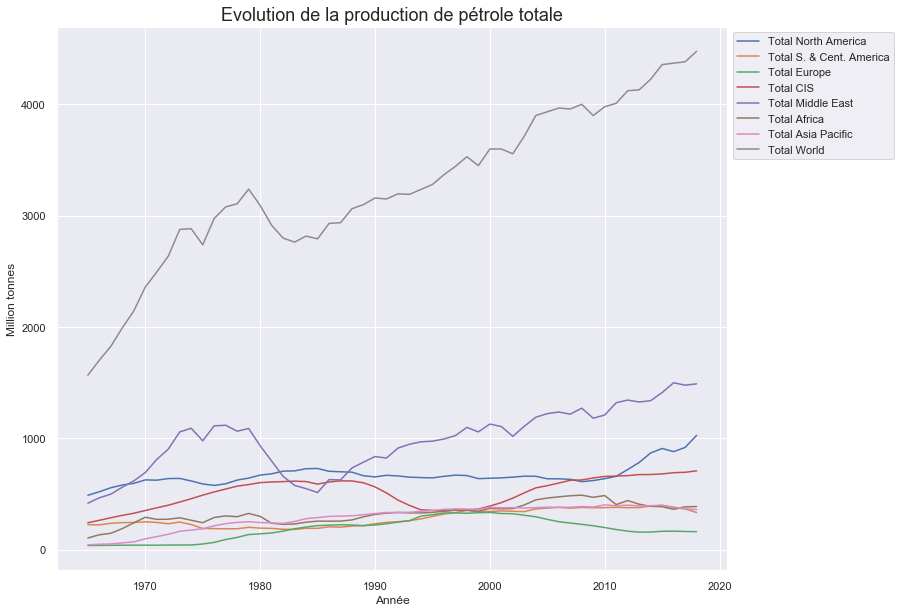

In [30]:
print_df(oil_production_total, "Evolution de la production de pétrole totale", unite)

## Gaz 

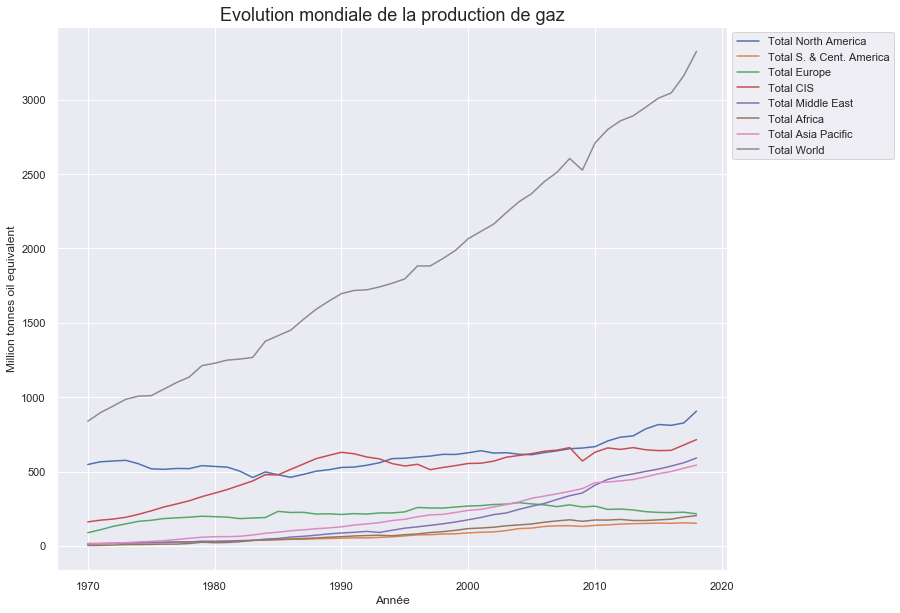

In [31]:
gaz_production = pd.read_excel(dataPath+"data_production.xlsx", 5, header = 2)
unite = "Million tonnes oil equivalent"
gaz_production = clean(gaz_production, unite)
gaz_production_total, gaz_production = separate_total(gaz_production, unite)
gaz_production_total, gaz_production = set_name_df(gaz_production_total, "Total gaz"), set_name_df(gaz_production_total, "gaz")
print_df(gaz_production_total, "Evolution mondiale de la production de gaz", unite)

## Charbon

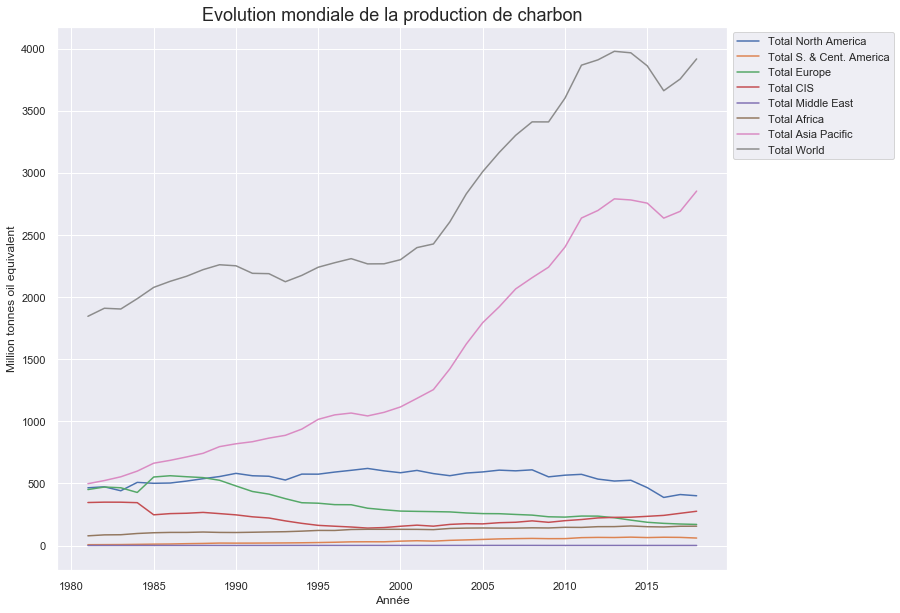

In [32]:
coal_production = pd.read_excel(dataPath+"data_production.xlsx", 7, header = 2)
unite = "Million tonnes oil equivalent"
coal_production = clean(coal_production,unite)
coal_production_total, coal_production = separate_total(coal_production, unite)
coal_production_total, coal_production = set_name_df(coal_production_total, "Total coal"), set_name_df(coal_production_total, "coal")
print_df(coal_production_total, "Evolution mondiale de la production de charbon", unite)

## Nucléaire 

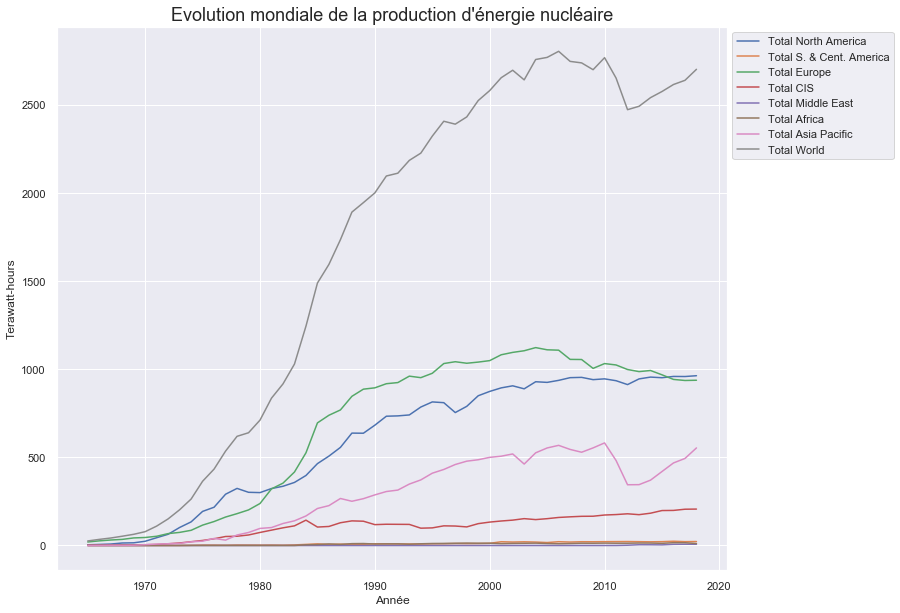

In [33]:
nuclear_production = pd.read_excel(dataPath+"data_production.xlsx", 8, header = 2)
unite = "Terawatt-hours"
nuclear_production = clean(nuclear_production,unite)
nuclear_production_total, nuclear_production = separate_total(nuclear_production, unite)
nuclear_production_total, nuclear_production = set_name_df(nuclear_production_total, "Total nuclear"), set_name_df(nuclear_production_total, "nuclear")
print_df(nuclear_production_total, "Evolution mondiale de la production d'énergie nucléaire", unite)

## Hydrolique

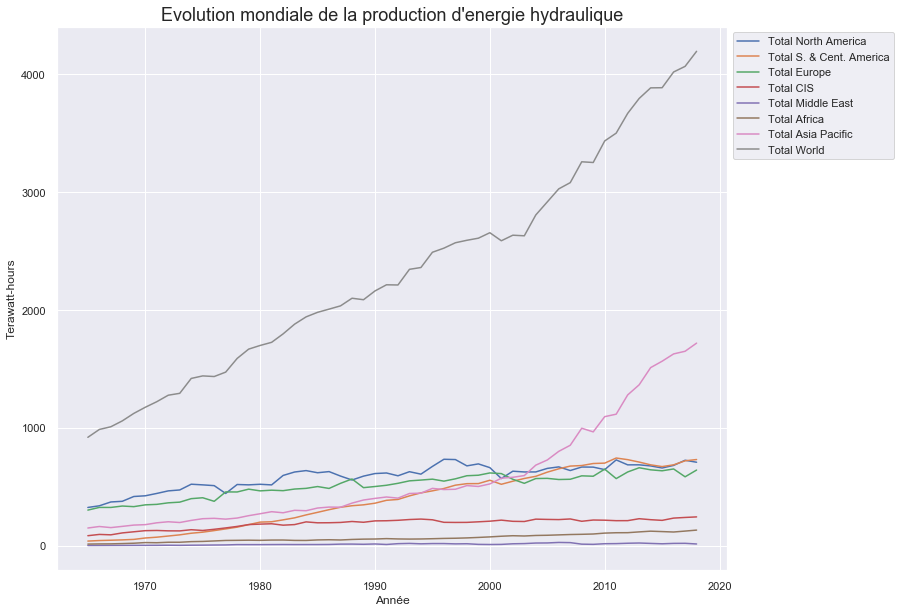

In [34]:
hydro_production = pd.read_excel(dataPath+"data_production.xlsx", 9, header = 2)
unite = "Terawatt-hours"
hydro_production = clean(hydro_production,unite)
hydro_production_total, hydro_production = separate_total(hydro_production, unite)
hydro_production_total, hydro_production = set_name_df(hydro_production_total, "Total hydro"), set_name_df(hydro_production_total, "hydro")
print_df(hydro_production_total, "Evolution mondiale de la production d'energie hydraulique", unite)

## Energies renouvelables 


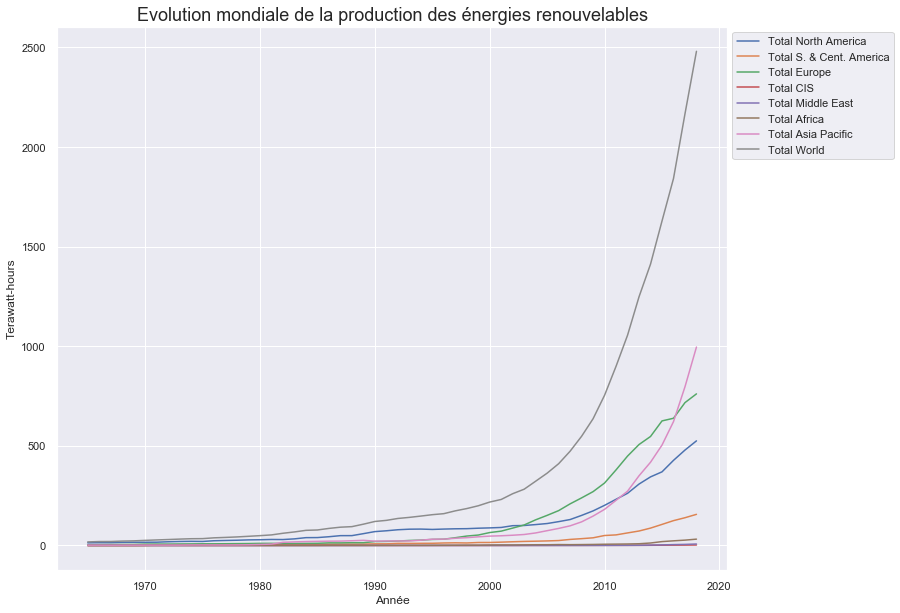

In [35]:
renewable_production = pd.read_excel(dataPath+"data_production.xlsx", 10, header = 2)
unite = "Terawatt-hours"
renewable_production = clean(renewable_production,unite)
renewable_production_total, renewable_production = separate_total(renewable_production, unite)
renewable_production_total, renewable_production = set_name_df(renewable_production_total, "Total renewable"), set_name_df(renewable_production_total, "renewable")
print_df(renewable_production_total, "Evolution mondiale de la production des énergies renouvelables", unite)

## Solaire 


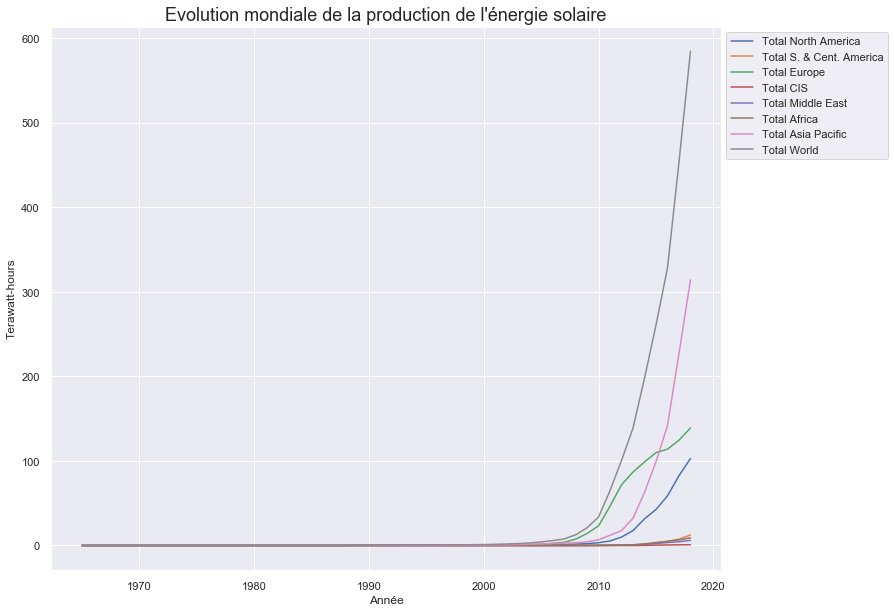

In [36]:
solar_production = pd.read_excel(dataPath+"data_production.xlsx", 12, header = 2)
unite = "Terawatt-hours"
solar_production = clean(solar_production,unite)
solar_production_total, solar_production = separate_total(solar_production, unite)
solar_production_total, solar_production = set_name_df(solar_production_total, "Total solar"), set_name_df(solar_production_total, "solar")
print_df(solar_production_total, "Evolution mondiale de la production de l'énergie solaire", unite)

## Vent 

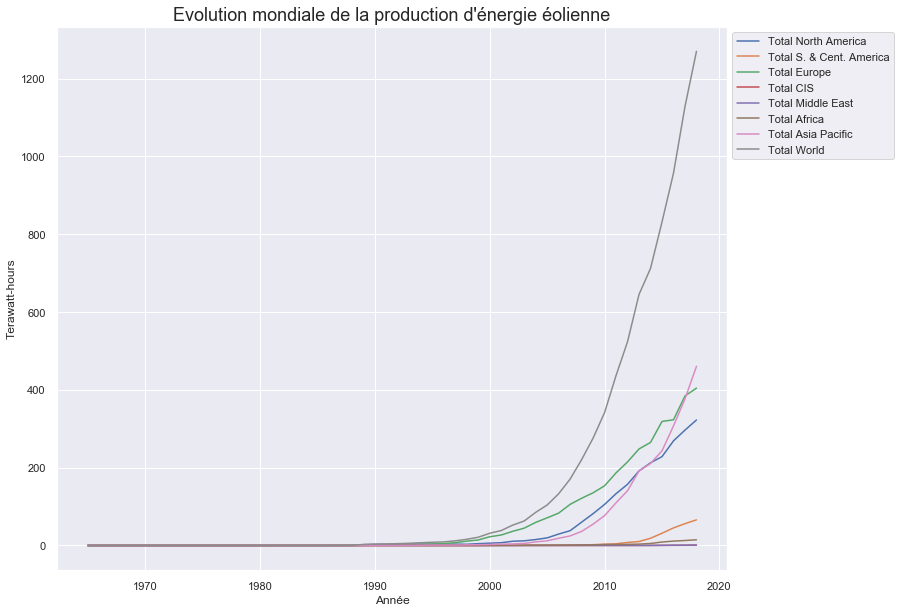

In [37]:
wind_production = pd.read_excel(dataPath+"data_production.xlsx", 13, header = 2)
unite = "Terawatt-hours"
wind_production = clean(wind_production,unite)
wind_production_total, wind_production = separate_total(wind_production, unite)
wind_production_total, wind_production = set_name_df(wind_production_total, "Total wind"), set_name_df(wind_production_total, "wind")

print_df(wind_production_total, "Evolution mondiale de la production d'énergie éolienne", unite)

## Biomass 

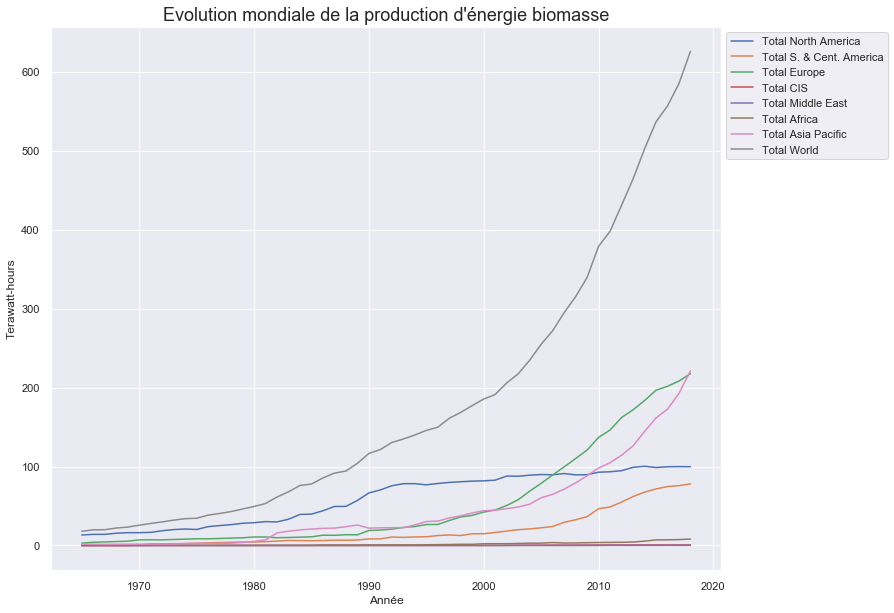

In [38]:
biomass_production = pd.read_excel(dataPath+"data_production.xlsx", 14, header = 2)
unite = "Terawatt-hours"
biomass_production = clean(biomass_production,unite)
biomass_production_total, biomass_production = separate_total(biomass_production, unite)
biomass_production_total, biomass_production = set_name_df(biomass_production_total, "Total biomass"), set_name_df(biomass_production_total, "biomass")
print_df(biomass_production_total, "Evolution mondiale de la production d'énergie biomasse", unite)


## Evolution du mix énergétique

In [39]:
def print_tot(list_df, title, unite) :
    plt.figure(figsize=(12,10))
    plt.title(title, fontSize=18)
    for k,df in enumerate(list_df) :   
        plt.plot(df.columns.values[:-5], df.iloc[-1][:-5], label=f"{df.name}")
    plt.legend(bbox_to_anchor = (1,1))
    plt.xlabel("Année")
    plt.ylabel(unite)
    plt.show()

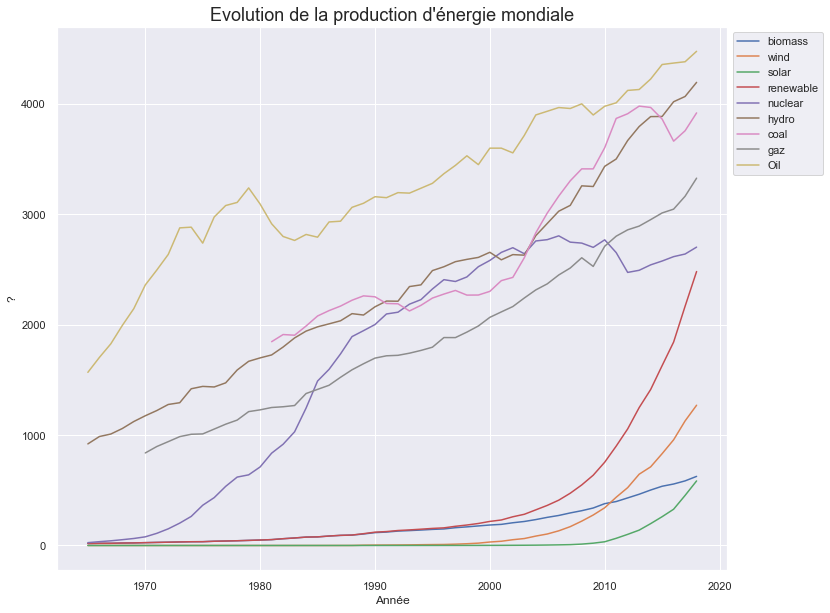

In [40]:
dfs= [biomass_production,wind_production,solar_production, renewable_production, 
           nuclear_production, hydro_production,coal_production, gaz_production, oil_production]
print_tot(dfs,
         title = "Evolution de la production d'énergie mondiale", unite="?")

In [94]:
px.histogram(final_df[final_df['Country']!='World'],x="Energy",y="Production",histfunc='sum',color='Date', title="Mix énergétique de 1982 à aujourd'hui")


**Observations :**

On constate que les énergies fossiles sont encore largement prédominantes, poussés par la l'Asie (notamment la Chine).
On remarque que l'arrivée des énergies renouvelables ne s'est rééllement produite qu'à partir des années 2010, mais suit depuis une croissance exponentielle

# Prédiction de l'évolution du mix et de la production énergétique jusqu'en 2050

## Régression linéaire 

Ici on va essayer de prédire les productions futures pour chaque type d'énergie via le modèle le plus simpliste : la régression linéaire avec pour seule variable d'explication la date. 

C'est bien évidemment un modèle inadapté à notre problème, notamment puisqu'on a remarqué que l'évolution de la production d'énergie renouvelable était exponentielle depuis 20 ans mais c'est toutefois une première approche.


In [41]:
dfs= [biomass_production_total,wind_production_total,solar_production_total, renewable_production_total, 
           nuclear_production_total, hydro_production_total,coal_production_total, gaz_production_total, oil_production_total]


In [42]:
min_date = min(coal_production.T.index.values[:-5].astype(int))

def reshape_data (df) :
    df_copy = df.copy()
    df_copy = df_copy.T
    df_copy = df_copy.reset_index()
    df_copy = df_copy [:-5]
    header = np.array(df_copy.columns)
    header[0] = 'Date'
    df_copy = df_copy[1:]
    df_copy.columns = header
    df_copy = df_copy.melt(id_vars=['Date'], value_name=df.name)
    df_copy = df_copy[df_copy["Date"]>min_date]
    df_copy.name = df.name
    return df_copy

def concat_sources (dfs) :
    dataframes = []
    for df in dfs : 
        dataframes.append(reshape_data(df))
    return_df = dataframes[0]
    for df in dataframes[1:] :
        return_df=return_df.merge(df, on=["Date", "variable"])
    return return_df

t =  concat_sources(dfs)
t_copy = t.copy()
t=t.melt(id_vars=['Date', 'variable'], var_name="Energy", value_name = "Production")
t.Production=t.Production.astype(float)
t.Date=t.Date.astype(int)

In [43]:
np.unique(t.variable.values)

array(['Total Africa', 'Total Asia Pacific', 'Total CIS', 'Total Europe',
       'Total Middle East', 'Total North America',
       'Total S. & Cent. America', 'Total World'], dtype=object)

In [44]:
t.variable = t.variable.str.replace("Total ","").str.replace('S. & Cent. America',"Latin America").str.replace("CIS", "Russia")


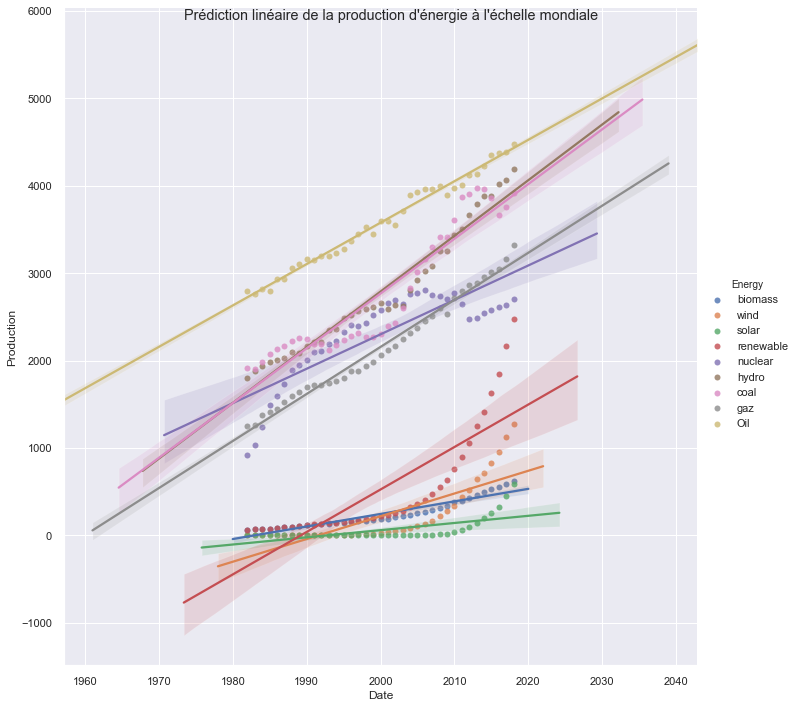

In [45]:

t_world=t[t["variable"]=="World"]
g = sns.lmplot(x="Date", y="Production", hue="Energy", data=t_world, height=10).fig.suptitle("Prédiction linéaire de la production d'énergie à l'échelle mondiale")


## Régression polynomiale

Ici on va essayer de prédire les productions futures pour chaque type d'énergie en fonction :
- de l'année
- du pays
- de la population
- de la population urbaine
- du PIB
- du PIB par habitant

On va fonctionné en 2 temps pour prédire la production entre 2019 et 2050 :
1. Prédiction de la population, population urbaine, PIB, PIB par habitant à partir de l'année et du pays
2. Prédiction de la production en fonction de toutes les données prédites

In [54]:
def predict(X_futur, final_df, region, energy, fig):
    europe_renewable = final_df[(final_df['Country'] == region) & (
        final_df['Energy'] == energy)].drop(columns=['Population Growth', 'CO2 Emission'])
    X_europe = europe_renewable['Date']
    y_europe = europe_renewable.drop(
        columns=['Date', 'Country', 'Energy', 'Production'])
    # Prediction des données démographiques futurs
    poly = PolynomialFeatures(2)
    X_poly = poly.fit_transform(X_europe.values.reshape(-1, 1))
    X_poly_futur = poly.fit_transform(X_futur.reshape(-1, 1))
    lr = LinearRegression().fit(X_poly, y_europe)
    y_predicted = lr.predict(X_poly_futur)
    X_futur_final = pd.DataFrame(X_futur, columns=['Date']).join(pd.DataFrame(y_predicted, columns=[
                          'Urban Population', 'Population', 'GDP in $']))
    y_train = europe_renewable['Production']
    X_train = europe_renewable.drop(
        columns=['Country', 'Energy', 'Production'])
    X_train['GDP per capita'] = X_train['GDP in $'] / X_train['Population']
    europe_renewable_present_futur = pd.concat([X_train, X_futur_final],sort=False)
    europe_renewable_present_futur['GDP per capita'] = europe_renewable_present_futur['GDP in $'] / \
        europe_renewable_present_futur['Population']
    europe_renewable_futur = X_futur_final.copy()
    europe_renewable_futur['GDP per capita'] = europe_renewable_futur['GDP in $'] / \
        europe_renewable_futur['Population']
    # Prédiction de la production futur
    poly2 = PolynomialFeatures(2)
    X_train_poly = poly2.fit_transform(X_train)
    X_test_poly = poly2.fit_transform(europe_renewable_futur)
    lr = LinearRegression().fit(X_train_poly, y_train)
    y_final = lr.predict(X_test_poly)
    prod = pd.concat([pd.DataFrame(y_train, columns=['Production']),
                     pd.DataFrame(y_final, columns=['Production'])],sort=False)
    final = europe_renewable_present_futur.join(prod)
    # Visualisation
    fig.add_trace(go.Scatter(x=final['Date'], y=final["Production"],name=energy))

    
final_df = pd.read_csv(f"{path}/Co2_predicted.csv")
X_futur=np.array(range(2019, 2050))
region='World'
energies=['Oil', 'biomass', 'coal', 'gaz', 'hydro',
    'nuclear', 'renewable', 'solar', 'wind']
fig = go.Figure()

for energy in energies:
    predict(X_futur, final_df, region, energy,fig)

fig.show()

**Limites de la régression polynomiale :**

- Les valeurs ont tendance à exploser, notamment pour les énergies renouvelables puisque la tendance des dernières années (ie une croissance très forte) est amplifié par la régression polynomiale, même en se restreignant au degré 2.
- Certaines valeurs finissent par devenir négative quand la tendance était à la baisse sur les dernières années 

$\Rightarrow$ La régression polynomiale n'est pas adaptée au Time Series 

## ARIMA 

Nous allons utiliser l'algorithme ARIMA (Auto Regressive Integrated Moving Average) qui est la combination de deux model : 

- Autoregressive model : Ce modèle consiste à récupérer les lags de notre time series (lag = valeur à un instant t-k). Par exemple en considérant l'instant présent t, le lag -2 de notre série corresponds à la valeur de notre série à l'instant t-2 et à les inclures dans la prédiction de nouvelles valeurs
- Moving Average : qui permets de dire que notre variable à prédire (la prochaine valeur de la timeserie) dépends linéairement des erreurs passées réalisés dans notre time-series

Cet algorithme est pour les prédictions des time series à une seule variable et performe mieux quand les données présentent une saisonalitée. 

**Récupération des données :**

In [59]:
production_energy_by_region = t.rename(columns={"variable":"Country"}).copy()
dataPath ='/'.join(os.getcwd().split("/")[:-1])

demographic_grouped = pd.read_csv(dataPath+"/demographic_grouped.csv" )

In [60]:
merged_data = pd.merge(production_energy_by_region,demographic_grouped, on=["Date","Country"])

In [61]:
merged_data_cleaned = merged_data.copy()

In [62]:
merged_data_cleaned=merged_data_cleaned.drop(["Access to Electricity", "Nitrous Oxyd Emission", "Methan Oxyd Emission"], axis =1)

In [63]:
pathToSave = '/'.join(os.getcwd().split("/")[:-1])
for energy in merged_data_cleaned.Energy.unique() :
    temp = merged_data_cleaned[merged_data_cleaned.Energy == energy]
    temp.to_csv(pathToSave+"/production_"+energy+".csv")


In [64]:

merged_data_cleaned.to_csv(pathToSave+"/Co2_predicted.csv", index = False)

In [65]:
data_to_predict = merged_data_cleaned[merged_data_cleaned.Country == "World"]

In [66]:
data_to_predict = data_to_predict.set_index("Date")

**Remplir les données manquantes avec une prédiction**

In [67]:
def predict_timeseries_ARIMA (serie, p, d, q, max_date) :
    """ This function predict values for a given time serie
    using ARIMA algorithm with parameters p, d, q from the last 
    known date until max_date
    
    parameters: 
    - serie : represent our serie, should be a pandas object
    - p, d, q : parameters for ARIMA, should be choosen wisely 
            by checking the autocorrelation. 
    - max_date : Represents the max_date to predict
    
    By Kevin FERIN
    """
    if (type(serie)== pd.core.frame.Series) :
        serie = serie.to_frame()
    serie = serie.dropna()
    #autocorrelation_plot(serie)
    #plt.show()
    date_known = serie.index
    date_to_predict = [i for i in range (max(date_known)+1,max_date)]
    history = [x for x in serie.values]
    predictions = list()
    for t in range(len(date_to_predict)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat[0])
        history.append(yhat[0])
    serie = serie.append(pd.DataFrame(data=predictions, index = date_to_predict, columns = serie.columns))
    return serie

In [68]:
data = data_to_predict.copy()
data = data.drop(["Country", "Energy", "Production"], axis = 1)
serie_predit = {}
for feature in data.columns :
    serie = data[feature].reset_index().groupby("Date").mean()
    serie.name = feature
    serie = predict_timeseries_ARIMA(serie , 5,1,0, max_date=2050)
    serie_predit[feature] = serie
    
#serie_predit

In [69]:
series = list(serie_predit.values())
df_to_predict = series[0]
for i in range(1,len(series)) : 
    df_to_predict = df_to_predict.join(series[i])

In [70]:
data_to_predict.Energy.unique() 

array(['biomass', 'wind', 'solar', 'renewable', 'nuclear', 'hydro',
       'coal', 'gaz', 'Oil'], dtype=object)

In [71]:
data = data_to_predict.copy()
for energy in data.Energy.unique() : 
    energyData = data[data.Energy==energy].Production
    energyData.name = energy
    df_to_predict = df_to_predict.join(energyData)

**Nous avons donc un DataFrame df_to_predict avec les différentes features intéressante prédit jusqu'en 2050 et les productions par types d'énergie encore à prédire. Nous allons le sauvegarder dans le but de ne pas le perdre.**

In [72]:
savePath ='/'.join(os.getcwd().split("/")[:-1])
df_to_predict.to_csv(savePath+"/results/feature_predicted_2050_productions_to_predict.csv", index=True)

In [73]:
predict_production = df_to_predict.copy()
for energy in data_to_predict.Energy.unique() :
    k = predict_timeseries_ARIMA(predict_production[energy], 1,2,0,2050)
    predict_production[energy] = k

In [74]:
predict_production.to_csv(savePath+"/results/production_predicted_2050.csv", index=True)

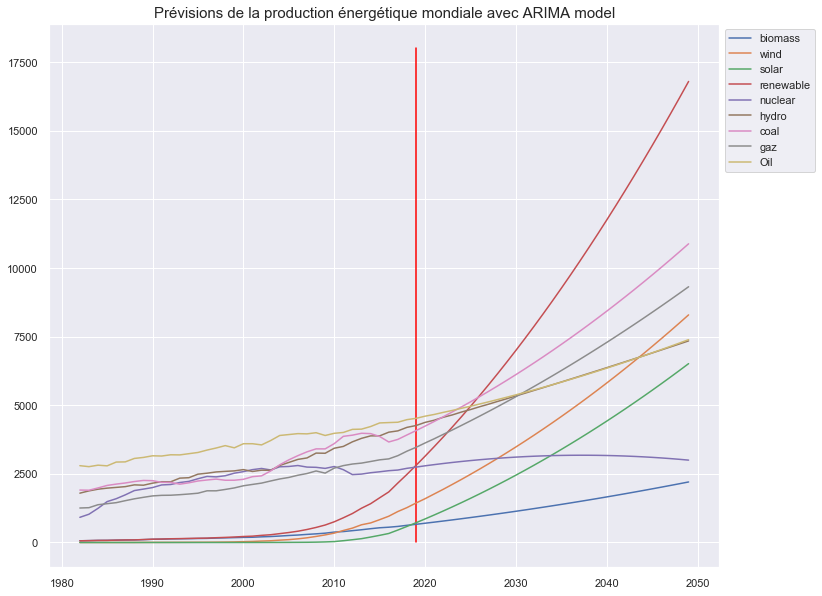

In [75]:
def plot_productions_predicted(df) :
    plt.figure(figsize=(12,10))
    plt.plot([datetime.now().year]*2,[0,18000], 'red')
    for energy in data_to_predict.Energy.unique()  :
        plt.plot(df[energy], label =f"{energy}")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title("Prévisions de la production énergétique mondiale avec ARIMA model", fontSize=15)
    
    plt.show()
plot_productions_predicted(predict_production)

## VAR Model : 

Cela corresponds à Vecteur Autoregressive Model. Ce model permets de prédire les valeurs de plusieurs paramètre en supposant que ces derniers influencent les autres. Nous allons prendre comme modèle les times series des productions des différentes sources d'énergies puis essayer de les prédire tous en même temps (dans un vecteur) en prenant en compte que si la production d'énergie renouvelable par exemple augmente fortement, les autres énergie ne peuvent pas augmenter de même. 

PS : Ceci est un test, je ne m'y connaît encore pas assez sur le sujet. Je vais sans doute faire des bétises sur les choix des hyperparamètres de ce modèle comme je l'ai fait également au dessus :) 

In [77]:
df_train = df_to_predict.copy()
df_train = df_train[data_to_predict.Energy.unique()].dropna()


In [78]:
model = VAR(df_train)
model_fitted = model.fit()

/Users/jeremieperes/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [83]:

yhat=model_fitted.forecast(model_fitted.endog, steps=30)

In [84]:
preds= [[ite[j] for ite in yhat] for j in range(len(yhat[0]))]

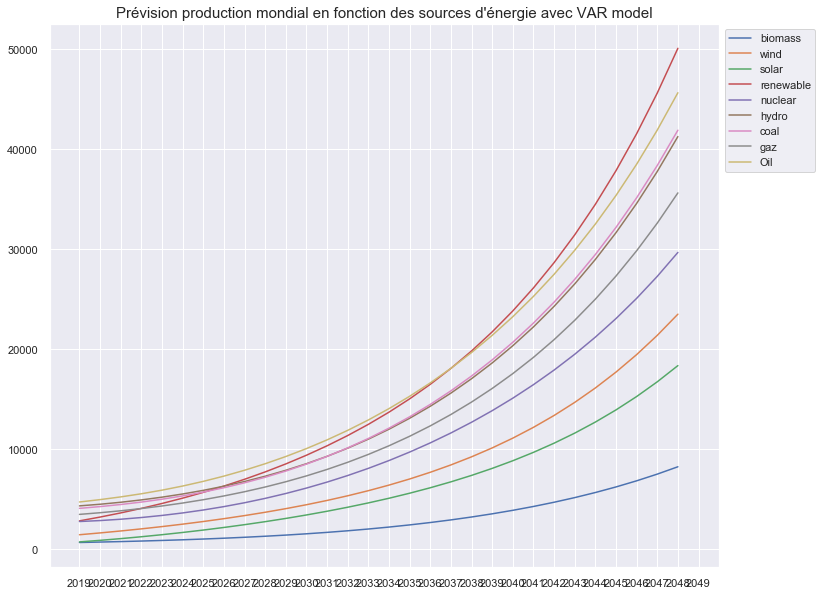

In [85]:
plt.figure(figsize=(12,10))
for k,el in enumerate(preds) : 
    plt.plot(el, label = f"{data.Energy.unique()[k]}")
plt.xticks(range(32), labels = [str(i) for i in range(2019,2050)])
plt.legend(bbox_to_anchor=(1,1))
plt.title("Prévision production mondial en fonction des sources d'énergie avec VAR model", fontSize=15)
plt.show();